# Introduction




# Prepare for analysis

## Load packages

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from load_data import load_data
from load_data import combine_train_test

from study_data import missing_data
from study_data import most_frequent_data
from study_data import unique_values
from study_data import unique_values_summary

from clean_data import add_family_size
from clean_data import add_age_interval
from clean_data import add_fare_interval_column
from clean_data import add_sex_pclass
from clean_data import extract_names
from clean_data import parse_names
from clean_data import add_family_type_column
from clean_data import assign_family_type
from clean_data import unify_titles
from clean_data import calculate_survival_rate_by_title_and_sex, map_sex_column


In [2]:
# TODO: Add all hard coded parameters like file paths or model parameters here
TRAIN_PATH = "/home/trapfishscott/Cambridge24.25/D400_FODS/titanic_problem_set/train.csv"
TEST_PATH = "/home/trapfishscott/Cambridge24.25/D400_FODS/titanic_problem_set/test.csv"

## Read the data

In [3]:
train_df = load_data(TRAIN_PATH)

# TODO: Put the path at the top of the script and replace with variable
test_df = load_data(TRAIN_PATH) 

# Preliminary data inspection

## Quick glimpse of the data
Comment out as needed.

In [4]:

# train_df.head()
# test_df.head()

# train_df.info()
# test_df.info()

# train_df.describe()
# test_df.describe()

## Few statistics on the data

### Missing data

In [5]:
## Missing training data
missing_data(train_df)


,Total,Percent,Types
PassengerId,0,0.000000,int64
Survived,0,0.000000,int64
Pclass,0,0.000000,int64
Name,0,0.000000,object
Sex,0,0.000000,object
Age,177,19.865320,float64
SibSp,0,0.000000,int64
Parch,0,0.000000,int64
Ticket,0,0.000000,object
Fare,0,0.000000,float64


In [6]:
# Missing test data
missing_data(test_df)

,Total,Percent,Types
PassengerId,0,0.000000,int64
Survived,0,0.000000,int64
Pclass,0,0.000000,int64
Name,0,0.000000,object
Sex,0,0.000000,object
Age,177,19.865320,float64
SibSp,0,0.000000,int64
Parch,0,0.000000,int64
Ticket,0,0.000000,object
Fare,0,0.000000,float64


### Most frequent data

Training Data

In [7]:

most_frequent_data(train_df)

,Total,Most frequent item,Frequence,Percent from total
PassengerId,891,891,1,0.112
Survived,891,0,549,61.616
Pclass,891,3,491,55.107
Name,891,"Dooley, Mr. Patrick",1,0.112
Sex,891,male,577,64.759
Age,714,24.0,30,4.202
SibSp,891,0,608,68.238
Parch,891,0,678,76.094
Ticket,891,347082,7,0.786
Fare,891,8.05,43,4.826


Testing Data

In [8]:
most_frequent_data(test_df)

,Total,Most frequent item,Frequence,Percent from total
PassengerId,891,891,1,0.112
Survived,891,0,549,61.616
Pclass,891,3,491,55.107
Name,891,"Dooley, Mr. Patrick",1,0.112
Sex,891,male,577,64.759
Age,714,24.0,30,4.202
SibSp,891,0,608,68.238
Parch,891,0,678,76.094
Ticket,891,347082,7,0.786
Fare,891,8.05,43,4.826


### Unique values

Training Data

In [9]:
unique_values_summary(train_df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Total,891,891,891,891,891,714,891,891,891,891,204,889
Uniques,891,2,3,891,2,88,7,7,681,248,147,3


Testing Data

In [10]:
unique_values_summary(test_df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Total,891,891,891,891,891,714,891,891,891,891,204,889
Uniques,891,2,3,891,2,88,7,7,681,248,147,3


# Exploratory data analysis

## Univariate analysis for all features


We show here two graphs in paralel:
* distribution of class values, split per Survived value
* comparison of class values, in train and test data


Let's first aggregate train and test data into one single dataframe, `all_df`.

In [11]:
all_df = combine_train_test(train_df, test_df, "Survived")

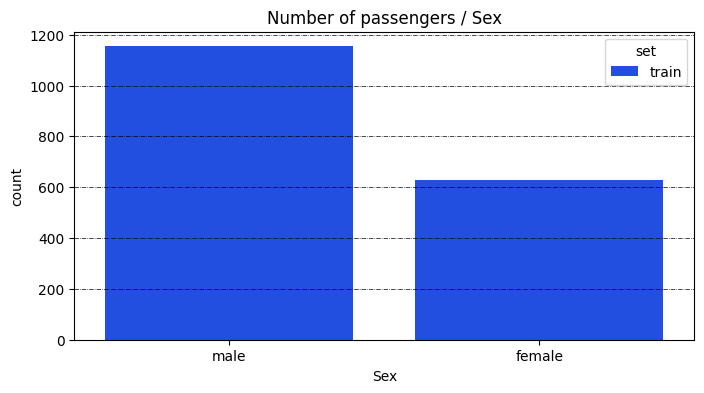

In [12]:
# Plot count pairs "Sex"
f, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.countplot(x="Sex", data=all_df, hue="set", palette="bright")
plt.grid(color="black", linestyle="-.", linewidth=0.5, axis="y", which="major")
ax.set_title("Number of passengers / Sex")
plt.show()  

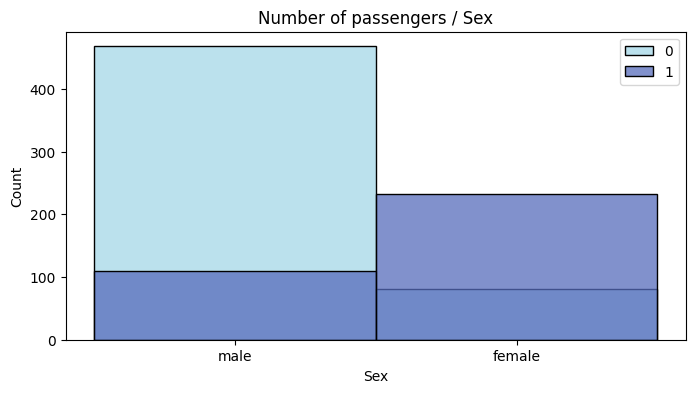

In [13]:
# Plot distribution pairs for "Sex" and hue as "Survived"
color_list = ["#A5D7E8", "#576CBC", "#19376D", "#0b2447"]
f, ax = plt.subplots(1, 1, figsize=(8, 4))
for i, h in enumerate(train_df["Survived"].unique()):
    g = sns.histplot(train_df.loc[train_df["Survived"]==h, "Sex"], 
                                  color=color_list[i], 
                                  ax=ax, 
                                  label=h)
ax.set_title("Number of passengers / Sex")
g.legend()
plt.show()

## Family size


Based on SibSp (sibilings or spouse) and Parch (parents or children), we set the Family Size field.

In [14]:
all_df = add_family_size(all_df)
train_df = add_family_size(train_df)
test_df = add_family_size(test_df)


## Age interval

In [15]:

all_df = add_age_interval(all_df)
train_df = add_age_interval(train_df)
test_df = add_age_interval(test_df)


## Fare interval

In [16]:
all_df = add_fare_interval_column(all_df)
train_df = add_fare_interval_column(train_df)
test_df = add_fare_interval_column(test_df)

## P-class + Sex

In [17]:
all_df = add_sex_pclass(all_df)
train_df = add_sex_pclass(train_df)
test_df = add_sex_pclass(test_df)

## Process names


When we process names, we would like to extract the following information:

- Family name - this is the first word (or few first words, if a family name with multiple names), followed by a comma  
- Title - this follows just after the comma   
- Given name - this is the word or group of words following family name  
- Maiden name - for ladies, is given between parantheses  

We start with creating a function that parses the Name string and extract (if possible) these 4 elements


In [18]:
all_df = extract_names(all_df)
train_df = extract_names(train_df)
test_df = extract_names(test_df)

## Multivariate analysis


Let's look now to the interaction of multiple features.

In [19]:
# TODO: Plot count pairs of "Age Interval" grouped by "Pclass"
def plot_age_interval_by_pclass(df):
    """
    Plot count of 'Age Interval' grouped by 'Pclass'.

    Parameters:
    df (pd.DataFrame): The DataFrame containing 'Age Interval' and 'Pclass' columns.
    """
    # Group by 'Pclass' and 'Age Interval' and count occurrences
    count_data = df.groupby(['Pclass', 'Age Interval']).size().reset_index(name='Count')

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Pclass', y='Count', hue='Age Interval', data=count_data, palette='viridis')
    
    # Adding title and labels
    plt.title('Count of Age Intervals by Passenger Class')
    plt.xlabel('Passenger Class')
    plt.ylabel('Count')
    plt.legend(title='Age Interval')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [20]:
# TODO: Plot count pairs of "Pclass" grouped by "Fare Interval"

def plot_pclass_by_fare_interval(df):
    """
    Plot count of 'Pclass' grouped by 'Fare Interval'.

    Parameters:
    df (pd.DataFrame): The DataFrame containing 'Pclass' and 'Fare Interval' columns.
    """
    # Group by 'Fare Interval' and 'Pclass' and count occurrences
    count_data = df.groupby(['Fare Interval', 'Pclass']).size().reset_index(name='Count')

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Fare Interval', y='Count', hue='Pclass', data=count_data, palette='viridis')
    
    # Adding title and labels
    plt.title('Count of Passenger Class by Fare Interval')
    plt.xlabel('Fare Interval')
    plt.ylabel('Count')
    plt.legend(title='Pclass')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Few more engineered data 


Let's create two more engineered features:  
* Family size interval: Single, Small, Large  
* Aggregated titles: Mr, Mrs, Master, Miss, and Rare  

In [21]:
add_family_type_column([all_df, train_df, test_df])

In [22]:
assign_family_type([all_df, train_df, test_df])

/home/trapfishscott/Cambridge24.25/D400_FODS/titanic_problem_set/clean_data.py:149: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Single' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[dataset["Family Size"] == 1, "Family Type"] = "Single"
/home/trapfishscott/Cambridge24.25/D400_FODS/titanic_problem_set/clean_data.py:149: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Single' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[dataset["Family Size"] == 1, "Family Type"] = "Single"
/home/trapfishscott/Cambridge24.25/D400_FODS/titanic_problem_set/clean_data.py:149: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Single' has dtype incompatible wi

In [23]:
for dataset in [all_df, train_df, test_df]:
    dataset["Titles"] = dataset["Title"]

In [24]:
all_datasets = [all_df, train_df, test_df]

In [25]:
unify_titles(all_datasets)
calculate_survival_rate_by_title_and_sex(all_datasets)
map_sex_column(all_datasets)

TypeError: list indices must be integers or slices, not list

# Baseline model

## Feature engineering: Map categorical value to numerical values

In [26]:
# TODO: turn into function


Create train-validation split.

In [27]:
VALID_SIZE = 0.2
train, valid = train_test_split(train_df, test_size=VALID_SIZE, random_state=42, shuffle=True)

Define predictor features and target feature.

In [28]:
predictors = ["Sex", "Pclass"]
target = 'Survived'

Define the training and validation data and labels.

In [29]:
# TODO: turn into function
prepare_datasets(train, valid, predictors, target):
    """
    Prepares the training and validation datasets by extracting the feature columns (predictors) and the target column.

    Parameters:
    train (pd.DataFrame): The training dataset.
    valid (pd.DataFrame): The validation dataset.
    predictors (list of str): List of column names to be used as predictors/features.
    target (str): The column name of the target variable.

    Returns:
    tuple: Returns four datasets: train_X, train_Y, valid_X, valid_Y.
    """
    # Extract feature columns and target columns for training
    train_X = train[predictors]
    train_Y = train[target].values

    # Extract feature columns and target columns for validation
    valid_X = valid[predictors]
    valid_Y = valid[target].values

    return train_X, train_Y, valid_X, valid_Y

SyntaxError: invalid syntax (3542268032.py, line 2)

Initialize the classifiction algorithm.

In [102]:
# TODO: could this and the following code cells be turned into a function that returns the prediction?


def train_and_predict_random_forest(train_X, train_Y, valid_X, random_state=42, n_estimators=100, criterion="gini"):
    """
    Trains a RandomForestClassifier on the training data and returns predictions for both training and validation sets.

    Parameters:
    train_X (pd.DataFrame): Features of the training dataset.
    train_Y (pd.Series or np.array): Target of the training dataset.
    valid_X (pd.DataFrame): Features of the validation dataset.
    random_state (int, optional): Random state for reproducibility. Default is 42.
    n_estimators (int, optional): The number of trees in the forest. Default is 100.
    criterion (str, optional): The function to measure the quality of a split. Default is "gini".

    Returns:
    tuple: Returns predictions for both training and validation sets.
    """
    # Initialize the RandomForestClassifier
    clf = RandomForestClassifier(n_jobs=-1, 
                                 random_state=random_state,
                                 criterion=criterion,
                                 n_estimators=n_estimators,
                                 verbose=False)

    # Fit the classifier to the training data
    clf.fit(train_X, train_Y)

    # Predict on the training and validation data
    preds_train = clf.predict(train_X)
    preds_valid = clf.predict(valid_X)

    return preds_train, preds_valid

Fit the classifier with the training data.

In [ ]:
clf.fit(train_X, train_Y)

Predict the train data (to check the training classification error).

In [104]:
preds_tr = clf.predict(train_X)

Predict the validation data.

In [105]:
preds = clf.predict(valid_X)

# Evaluation

## Classification report for training data.

In [ ]:
print(metrics.classification_report(train_Y, preds_tr, target_names=['Not Survived', 'Survived']))

Classification report for validation data.

In [ ]:
print(metrics.classification_report(valid_Y, preds, target_names=['Not Survived', 'Survived']))